## Cutting Planes

In many applications there are strong formulations that may include an exponential number of constraints. These formulations cannot be direct handled by the MIP Solver: entering all these constraints
at once is usually not practical, except for very small instances. In the Cutting Planes [Dantz54] method
the LP relaxation is solved and only constraints which are violated are inserted. The model is re-optimized
and at each iteration a stronger formulation is obtained until no more violated inequalities are found.
The problem of discovering which are the missing violated constraints is also an optimization problem
(finding the most violated inequality) and it is called the Separation Problem.
As an example, consider the Traveling Salesman Problem. The compact formulation (Section 4.2) is a
weak formulation: dual bounds produced at the root node of the search tree are distant from the optimal
solution cost and improving these bounds requires a potentially intractable number of branchings. In
this case, the culprit are the sub-tour elimination constraints linking variables 𝑥 and 𝑦. A much stronger
TSP formulation can be written as follows: consider a graph 𝐺 = (𝑁, 𝐴) where 𝑁 is the set of nodes
and 𝐴 is the set of directed edges with associated traveling costs 𝑐𝑎 ∈ 𝐴. Selection of arcs is done with
binary variables 𝑥𝑎 ∀𝑎 ∈ 𝐴. Consider also that edges arriving and leaving a node 𝑛 are indicated in 𝐴+
𝑛
and 𝐴−
𝑛
, respectively. The complete formulation follows:

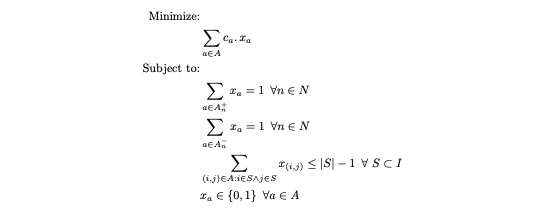

The third constraints are sub-tour elimination constraints. Since these constraints are stated for every
subset of nodes, the number of these constraints is 𝑂(2|𝑁|
). These are the constraints that will be
separated by our cutting pane algorithm. As an example, consider the following graph:

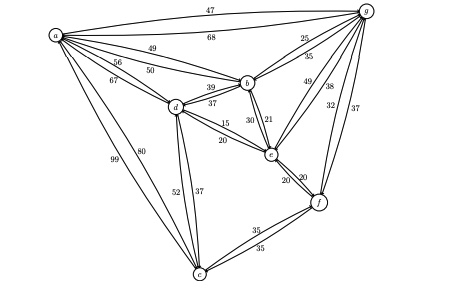

The optimal LP relaxation of the previous formulation without the sub-tour elimination constraints has
cost 237:

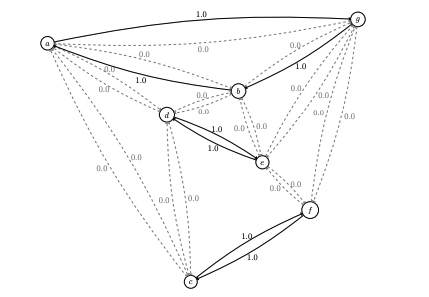

As it can be seen, there are tree disconnected sub-tours. Two of these include only two nodes. Forbidding
sub-tours of size 2 is quite easy: in this case we only need to include the additional constraints: 𝑥(𝑑,𝑒) +
𝑥(𝑒,𝑑) ≤ 1 and 𝑥(𝑐,𝑓) + 𝑥(𝑓,𝑐) ≤ 1.
Optimizing with these two additional constraints the objective value increases to 244 and the following
new solution is generated:

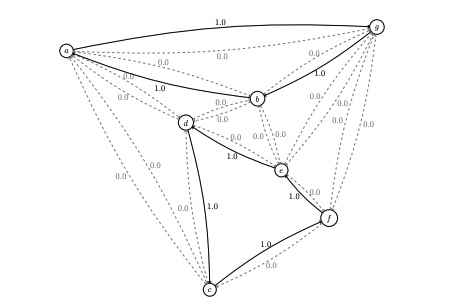

Now there are sub-tours of size 3 and 4. Let’s consider the sub-tour defined by nodes 𝑆 = {𝑎, 𝑏, 𝑔}. The
valid inequality for 𝑆 is: 𝑥(𝑎,𝑔) + 𝑥(𝑔,𝑎) + 𝑥(𝑎,𝑏) + 𝑥(𝑏,𝑎) + 𝑥(𝑏,𝑔) + 𝑥(𝑔,𝑏) ≤ 2. Adding this cut to our model
increases the objective value to 261, a significant improvement. In our example, the visual identification
of the isolated subset is easy, but how to automatically identify these subsets efficiently in the general
case ? Isolated subsets can be identified when a cut is found in the graph defined by arcs active in
the unfeasible solution. To identify the most isolated subsets we just have to solve the Minimum cut
problem in graphs. In python you can use the networkx min-cut module. The following code implements
a cutting plane algorithm for the asymmetric traveling salesman problem:

In [1]:
from itertools import product
from networkx import minimum_cut, DiGraph
from mip import Model, xsum, BINARY, OptimizationStatus, CutType

N = ["a", "b", "c", "d", "e", "f", "g"]
A = { ("a", "d"): 56, ("d", "a"): 67, ("a", "b"): 49, ("b", "a"): 50,
      ("f", "c"): 35, ("g", "b"): 35, ("g", "b"): 35, ("b", "g"): 25,
      ("a", "c"): 80, ("c", "a"): 99, ("e", "f"): 20, ("f", "e"): 20,
      ("g", "e"): 38, ("e", "g"): 49, ("g", "f"): 37, ("f", "g"): 32,
      ("b", "e"): 21, ("e", "b"): 30, ("a", "g"): 47, ("g", "a"): 68,
      ("d", "c"): 37, ("c", "d"): 52, ("d", "e"): 15, ("e", "d"): 20,
      ("d", "b"): 39, ("b", "d"): 37, ("c", "f"): 35, }
Aout = {n: [a for a in A if a[0] == n] for n in N}
Ain = {n: [a for a in A if a[1] == n] for n in N}

m = Model()
x = {a: m.add_var(name="x({},{})".format(a[0], a[1]), var_type=BINARY) for a in A}

m.objective = xsum(c * x[a] for a, c in A.items())

for n in N:
    m += xsum(x[a] for a in Aout[n]) == 1, "out({})".format(n)
    m += xsum(x[a] for a in Ain[n]) == 1, "in({})".format(n)

newConstraints = True

while newConstraints:
    m.optimize(relax=True)
    print("status: {} objective value : {}".format(m.status, m.objective_value))

    G = DiGraph()
    for a in A:
        G.add_edge(a[0], a[1], capacity=x[a].x)

    newConstraints = False
    for (n1, n2) in [(i, j) for (i, j) in product(N, N) if i != j]:
        cut_value, (S, NS) = minimum_cut(G, n1, n2)
        if cut_value <= 0.99:
            m += (xsum(x[a] for a in A if (a[0] in S and a[1] in S)) <= len(S) - 1)
            newConstraints = True
    if not newConstraints and m.solver_name.lower() == "cbc":
        cp = m.generate_cuts([CutType.GOMORY, CutType.MIR, 
                              CutType.ZERO_HALF, CutType.KNAPSACK_COVER])
        if cp.cuts:
            m += cp
            newConstraints = True

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

status: OptimizationStatus.OPTIMAL objective value : 237.0
Coin0506I Presolve 14 (0) rows, 26 (0) columns and 52 (0) elements
Clp1000I sum of infeasibilities 6.17798e-07 - average 4.41284e-08, 5 fixed columns
Coin0506I Presolve 6 (-8) rows, 9 (-17) columns and 18 (-34) elements
Clp0029I End of values pass after 9 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000111 - largest nonzero change 2.9213385e-05 ( 0.0014606692%) - largest zero change 2.3179938e-05
Clp0000I Optimal - objective value 237
Clp0000I Optimal - objective value 237
Coin0511I After Postsolve, objective 237, infeasibilities - dual 6.9999999 (1), primal 0 (0)
Coin0512I Presolved model was optimal, full model needs cleaning up
Clp0014I Perturbing problem by 0.001% of 1.0000038 - largest nonzero change 2.9213385e-05 ( 0.0014606692%) - largest zero change 2.88